In [2]:

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, make_scorer, accuracy_score, mean_squared_error
from nltk.stem import WordNetLemmatizer as Lemmatizer
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import re
from src.logit_gb import LogitGB

In [8]:
with open('data/text.p', 'rb') as file:
    text = pickle.load(file)
with open('data/target.p', 'rb') as file:
    target = pickle.load(file)
with open('models/vec.p', 'rb') as file:
    vec = pickle.load(file)

In [4]:
with open('data/predictor.p', 'rb') as file:
    predictor = pickle.load(file)

In [5]:
with open('data/pred_trimmed.p', 'rb') as file:
    pred = pickle.load(file)

In [13]:
with open('models/model_up.p', 'rb') as file:
    model = pickle.load(file)

In [123]:
pred = predictor[predictor['status'] == 'ISSUED']
pred['has_existing_stories'] = (pred['existing_stories'] > 0).astype(int)

C:\Users\pengj\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
n = 50000
sample_idx = np.random.choice(len(text), n)
train = np.full(n, False)
train_idx = np.random.choice(n, int(.75*n), replace = False)
for idx in train_idx:
    train[idx] = True
test = ~train

In [14]:
with open('data/full_df.p', 'rb') as file:
    predictor = pickle.load(file)

In [3]:
with open('vectorizer.p', 'rb') as file:
    vec = pickle.load(file)

In [7]:
X_text = vec.transform(text[sample_idx])

NameError: name 'vec' is not defined

In [24]:
X_text

<50000x13590 sparse matrix of type '<class 'numpy.float64'>'
	with 733680 stored elements in Compressed Sparse Row format>

In [9]:
with open('model_down.p', 'rb') as file:
    model_down = pickle.load(file)

In [43]:
y_pred = model.predict(pred.iloc[sample_idx], X_text)

In [41]:
y_true = ((target['fire_rate_after'] > target['fire_rate_before']).astype(int).values)[sample_idx]

In [44]:
f1_score(y_true, y_pred)

0.6142569890380748

In [9]:
vocab_idx = {value:key for key, value in vec.vocabulary_.items()}

In [17]:
model.m1.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [56]:
words = Counter()
for word, idx in vec.vocabulary_.items():
    words[word] = model.m1.coef_[0][idx]

In [59]:
increasing_words = words.most_common(20)

In [85]:
with open('model_down.p', 'rb') as file:
    model2 = pickle.load(file)

In [223]:
decreasing_words = Counter()
for word, idx in vec.vocabulary_.items():
    decreasing_words[word] = model2.m1.coef_[0][idx]

In [224]:
decreasing_words = decreasing_words.most_common(30)

In [226]:
common_decreasing_words = [(word, value) for (word, value) in decreasing_words if word in [a for (a,b) in decreasing_words_2]]

In [73]:
[(word, value) for (word, value) in increasing_words if word in [a for (a,b) in increasing_words_2]]

[('maher', 4.297130886122327),
 ('traps', 2.771010958474437),
 ('apt', 2.3895517975872798),
 ('ref', 2.2293113284246777),
 ('deferred', 2.075460798600689),
 ('mep', 1.9867622870982637),
 ('ordinance', 1.9859563962240923),
 ('exh', 1.8149284320503605)]

In [74]:
common_increasing_words = [('maher', 4.297130886122327),
 ('traps', 2.771010958474437),
 ('apt', 2.3895517975872798),
 ('ref', 2.2293113284246777),
 ('deferred', 2.075460798600689),
 ('mep', 1.9867622870982637),
 ('ordinance', 1.9859563962240923),
 ('exh', 1.8149284320503605)]

In [75]:
common_increasing_words

[('maher', 4.297130886122327),
 ('traps', 2.771010958474437),
 ('apt', 2.3895517975872798),
 ('ref', 2.2293113284246777),
 ('deferred', 2.075460798600689),
 ('mep', 1.9867622870982637),
 ('ordinance', 1.9859563962240923),
 ('exh', 1.8149284320503605)]

In [228]:
ratios = {}

In [229]:
for word, coef in common_decreasing_words:
    x = 0
    y = 0
    z = 0
    for i, row in pred[pred['description'].astype(str).apply(lambda x: word.upper() in x)].iterrows():
        try:
            increase = target.iloc[i]['fire_rate_after'] - target.iloc[i]['fire_rate_before']
        except:
            continue
        if increase > 0:
            x += 1
        elif increase == 0:
            y += 1
        else:
            z += 1
            #print(row['description'], increase)
    ratios[word] = (x,y,z)

In [88]:
with open('data/ratios_up.p', 'rb') as file:
    ratios_up = pickle.load(file)

In [231]:
ratios_down = pd.DataFrame(ratios).T

In [235]:
ratios_down.columns = ['increase', 'same', 'decrease']

In [90]:
ratios_down

,increase,same,decrease
office,2478.0,5477.0,1478.0
nan,7975.0,10687.0,2703.0
el,28992.0,89780.0,16055.0
sale,174.0,261.0,118.0
corridor,569.0,560.0,370.0
flourescent,13.0,551.0,163.0
general,66271.0,313753.0,43075.0


In [241]:
ratios_up

,increase,same,decrease,ir
maher,17946,18404,1464,12.258197
traps,454,95,8,56.750000
apt,3152,6321,759,4.152833
ref,12313,18399,1950,6.314359
deferred,441,655,69,6.391304
mep,3201,2616,614,5.213355
ordinance,5046,6602,610,8.272131
exh,1113,1421,326,3.414110
general,66271,313753,43075,1.538503
maher negative,48325,295349,41611,1.161352


In [84]:
pred[pred['description'].apply(lambda x: 'CORRIDOR' in x)]['description'].sample(20).values

array(['EXTENSION AT CORRIDOR TO CONNECT TO EXISTING STAIR/EXIT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ',
       '4TH FLOOR: REVISION TO PERMIT # 2018-0716-4635. REMOVE DOOR IN CORRIDOR.',
       '4 STORY REMODEL OF 2 UNITS BLDG(INCL ELECT.)G/F:(N)KITCHEN;(RE) BATH(N)STAIRS TO 2/F;(N) FIRE RATED CORRIDOR TO YARD (N)FRONT DOOR; 2/F:RELOCATE K

In [22]:
fires['date'].iloc[0].year

2019

In [16]:
with open('data/fires_df.p', 'rb') as file:
    fires = pickle.load(file)

In [23]:
fires['year'] = fires['date'].apply(lambda x: x.year)

In [50]:
filterd.iloc[5000]

address    1254 TAYLOR ST 7
year                   2015
date                      1
Name: 5000, dtype: object

In [41]:
dict = {}

In [42]:
for address in filterd['address'].unique():
    dict[address] = filterd[filterd['address'] == address] 

In [54]:
filterd['address'].sample(20)

8146                   150 POWELL STREET
11384                        18 OTIS ST.
36689        ALEMANY SB BL/PUTNAM STREET
13973                   207 JUSTIN DRIVE
33041                 771 - 773 24TH AV.
39223            EARL ST/KIRKWOOD AVENUE
26029                    450 EDDY ST 302
19529                      2888 16TH ST.
38325              CHANNEL ST. / 3RD ST.
40363               GEARY BL/33RD AVENUE
21476                       33 WHITE ST.
42533    LAKE MERCED BL. / BERKSHIRE WY.
9599                    163 ALHAMBRA ST.
7972                      15 BALDWIN CT.
16657                      2400 22ND ST.
29562               5TH ST. / HOWARD ST.
19958                        299 2ND ST.
46686         VALLEJO ST. / VAN NESS AV.
24753                        41 LAKE ST.
17211              24TH ST / SAN JOSE AV
Name: address, dtype: object

In [6]:
import pickle

In [19]:
with open('models/model.p', 'rb') as file:
    model2 = pickle.load(file)

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.2 when

In [3]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

C:\Users\pengj\Anaconda2\envs\threesix\lib\site-packages\sklearn\ensemble\partial_dependence.py:391: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.6851733428154316, top=-0.6851733428154316
  ax.set_ylim(pdp_lim[1])


(<Figure size 1440x720 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2760ad4e6a0>])

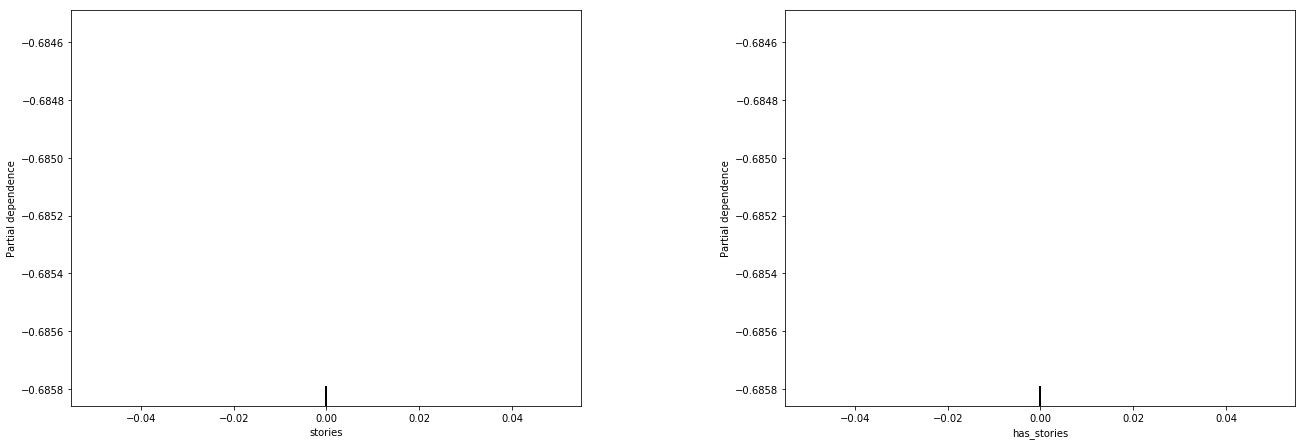

In [14]:
plot_partial_dependence(model2.m2, model2.X_final, features = [0,1], feature_names = ['stories', 'has_stories', 'text_pred'], figsize = (20,10))

In [5]:
predictor['address'].unique()

array(['705 SHOTWELL', '142 DIAMOND', '148 DIAMOND', ..., '20 LUNADO',
       '289 LILY', '679 VIENNA'], dtype=object)

In [96]:
r = requests.get("https://www.google.com/maps/place/679+vienna+San+Francisco")

In [97]:
from bs4 import BeautifulSoup

In [98]:
soup = BeautifulSoup(r.content, 'html.parser')

In [99]:
soup.find_all('meta')

[<meta content=" Find local businesses, view maps and get driving directions in Google Maps. " name="Description"/>,
 <meta content="initial-scale=1.0, maximum-scale=1.0, minimum-scale=1.0, user-scalable=no" name="viewport"/>,
 <meta content="chrome=1" http-equiv="X-UA-Compatible"/>,
 <meta content="notranslate" name="google"/>,
 <meta content="origin" name="referrer"/>,
 <meta content="Google Maps" itemprop="name"/>,
 <meta content="Google Maps" property="og:title"/>,
 <meta content="https://maps.google.com/maps/api/staticmap?center=0.0%2C0.0&amp;zoom=15&amp;size=256x256&amp;language=en&amp;sensor=false&amp;client=google-maps-frontend&amp;signature=VtVVKWqwu4TqFAryUUHdh4l_NoY" itemprop="image"/>,
 <meta content="https://maps.google.com/maps/api/staticmap?center=0.0%2C0.0&amp;zoom=15&amp;size=256x256&amp;language=en&amp;sensor=false&amp;client=google-maps-frontend&amp;signature=VtVVKWqwu4TqFAryUUHdh4l_NoY" property="og:image"/>,
 <meta content="256" property="og:image:width"/>,
 <meta 

In [100]:
coord = [float(x) for x in soup.find_all('meta')[7]['content'].split('=')[-1].split(',')]

ValueError: could not convert string to float: 'VtVVKWqwu4TqFAryUUHdh4l_NoY'

In [101]:
tuple(coord)

(37.72209, -122.471574)

In [8]:
predictor['address'].unique()[3].split()

['4089', '26TH']

In [7]:
failures = []

In [54]:
predictor['zip_code'] = predictor['zip_code'].astype(str)

In [88]:
commas = predictor[['address', 'sf', 'ca']].fillna('').apply(lambda x: ','.join(x), axis = 1)

In [91]:
commas = commas.reset_index()

In [77]:
commas['index'] = commas['index'].astype(str)

In [110]:
commas = commas.apply(lambda x: ','.join(x), axis = 1)

In [96]:
commas['level_0'] = commas['level_0'].astype(str)

In [116]:
s = "\n".join(commas.values[:10000])

In [128]:
spaces = predictor[['address', 'sf', 'ca']].fillna('').apply(lambda x: ' '.join(x), axis = 1)

In [117]:
with open('addresses/10000.csv', 'w') as file:
    file.write(s)

In [27]:
mkdir addresses

In [101]:
predictor.columns

Index(['15_day_hold?', 'application_number', 'assessor_stories',
       'avs_street_name', 'avs_street_sfx', 'block', 'city', 'company_name',
       'contact_name', 'contact_phone', 'contractorphone', 'description',
       'estimated_cost', 'existing_stories', 'existing_units', 'existing_use',
       'expiration_date', 'file_date', 'first_name', 'form_number',
       'last_name', 'lot', 'no of pages', 'plansets', 'proposed_stories',
       'proposed_units', 'proposed_use', 'revised_cost', 'state', 'status',
       'status_code', 'status_date', 'street', 'street_number',
       'street_number.1', 'street_number_sfx', 'street_suffix', 'unit',
       'unit_sfx', 'voluntary soft-story retrofit', 'zip_code', 'address',
       'sf', 'ca'],
      dtype='object')

In [131]:
r = requests.get('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?address=' + spaces.iloc[0] + '&benchmark=9&format=json')

In [147]:
time.clock()

4477.7990912

In [140]:
locations = {}

In [148]:
start_time = time.clock()
for i, address in enumerate(predictor['address'].unique()):
    
    r = requests.get('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?address=' + address + ' San Francisco CA&benchmark=9&format=json')
    try:
        locations[address] = tuple(r.json()['result']['addressMatches'][0]['coordinates'].values())
    except:
        print(i, address)
    if i % 500 == 0:
        print(i, time.clock() - start_time)
        

0 1.0566562999993039
6 50 03RD
33 1371 05TH
37 98 09TH
38 96 09TH
41 205 09TH
55 590 BOSWORTH
97 475 09TH
121 656 05TH
126 3801 03RD
142 663 05TH
143 665 05TH
155 125 03RD
164 151 03RD
169 6600 03RD
171 223 09TH
172 225 09TH
173 655 BROTHERHOOD
175 4408 03RD
176 4410 03RD
183 642 05TH
186 1307 05TH
214 746 05TH
218 85 05TH
227 5 03RD
240 625 03RD
249 201 03RD
259 685 03RD
260 6518 03RD
262 5700 03RD


KeyboardInterrupt: 

In [139]:
tuple(r.json()['result']['addressMatches'][0]['coordinates'].values())

(-122.415596, 37.757095)

In [152]:
addresses

array(['705 SHOTWELL', '142 DIAMOND', '148 DIAMOND', ..., '20 LUNADO',
       '289 LILY', '679 VIENNA'], dtype=object)

In [156]:
a

array(['705 SHOTWELL', '142 DIAMOND', '148 DIAMOND', ..., '20 LUNADO',
       '289 LILY', '679 VIENNA'], dtype=object)

In [159]:
with open('vectorizer.p', 'rb') as file:
    vec = pickle.load(file)

In [160]:
X_text = vec.transform(text)

In [18]:
from sklearn.decomposition import NMF

In [19]:
vocab_idx = {value:key for (key, value) in vec.vocabulary_.items()}

In [20]:
word_clusters = {}

In [254]:
for i in range(2,11):
    nmf = NMF(n_components = i)
    nmf.fit(X_text)
    B = nmf.components_
    A = nmf.transform(X_text)
    word_clusters[i] = np.array([[vocab_idx[idx] for idx in row][::-1] for row in B.argsort()[:,-11:]])

In [23]:
X_text = vec.transform(text)

In [27]:
nmf = NMF(n_components = 6)
nmf.fit(X_text)
B = nmf.components_
A = nmf.transform(X_text)
word_clusters = np.array([[vocab_idx[idx] for idx in row][::-1] for row in B.argsort()[:,-11:]])

In [1]:
word_clusters

NameError: name 'word_clusters' is not defined

In [31]:
with open('data/predictor.p', 'rb') as file:
    pred = pickle.load(file)

In [33]:
pred.shape

(423099, 45)

In [34]:
A.shape

(423099, 6)

In [35]:
for i in range(6):
    pred['topic ' + str(i)] = A[:,i]

In [37]:
with open('data/predictor.p', 'wb') as file:
    pickle.dump(pred, file)

In [282]:
with open('results/word_clusters.p', 'wb') as file:
    pickle.dump(word_clusters, file)

In [281]:
text[40000]

'family dwelling family dwelling remodel kitchen-upgrad electrical plumbing. insulate a needed. sheetrock with type x. hange new nan'